# Thư viện

In [1]:
import glob
import polars as pl
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np

# Tải dữ liệu

In [2]:
path_to_items = "data/sales_pers.item_chunk_0.parquet"
path_to_purchases = "data/sales_pers.purchase_history_daily_chunk_*.parquet"
path_to_customers = "data/sales_pers.customer_chunk_*.parquet"

item_df = pl.scan_parquet(path_to_items)
customer_df = pl.scan_parquet(glob.glob(path_to_customers))
purchase_df = pl.scan_parquet(glob.glob(path_to_purchases))

# Đặc trưng 1: Số tiền giao dịch trung bình cho một lần mua hàng, và phân cụm số tiền giao dịch trung bình đó, gán vào 3 nhãn "Bình dân", "Trung cấp" và "cao cấp". 

## Tìm tổng tiền giao dịch của mỗi khách hàng theo ngày

In [3]:
transactions_df = purchase_df.group_by(["customer_id", "created_date"]).agg(
    (pl.col("price") * pl.col("quantity")).sum().alias("transaction_value")
).collect()

transactions_df

customer_id,created_date,transaction_value
i32,datetime[μs],"decimal[38,4]"
4823876,2024-02-01 21:45:57,9000.0000
6452955,2024-06-19 15:28:44.500,125000.0000
4786714,2024-02-25 20:52:10.280,345000.0000
1656892,2024-11-14 15:26:28.870,275000.0000
4229511,2024-06-08 16:42:43.707,127500.0000
…,…,…
5588549,2024-04-06 17:25:22.867,1585000.0000
583126,2024-12-03 19:23:53.537,846000.0000
1198734,2024-07-31 19:21:26.027,294000.0000


In [4]:
avg_transaction_df = transactions_df.group_by("customer_id").agg(
    pl.col("transaction_value").mean().alias("avg_transaction_value")
)

avg_transaction_df

customer_id,avg_transaction_value
i32,f64
1872353,818000.0
7629523,415000.0
7379678,388525.0
5631853,363333.333333
2617690,1.3416e6
…,…
6870410,590166.66665
6065980,378000.0
7609176,85000.0


## Khám phá dữ liệu

In [5]:
avg_transaction_df.select(pl.col('avg_transaction_value')).describe()

statistic,avg_transaction_value
str,f64
"""count""",2.442306e6
"""null_count""",0.0
"""mean""",404671.301935
"""std""",366792.901218
"""min""",1.9999
"""25%""",176000.0
"""50%""",321599.999967
"""75%""",526000.0
"""max""",4.810836e7


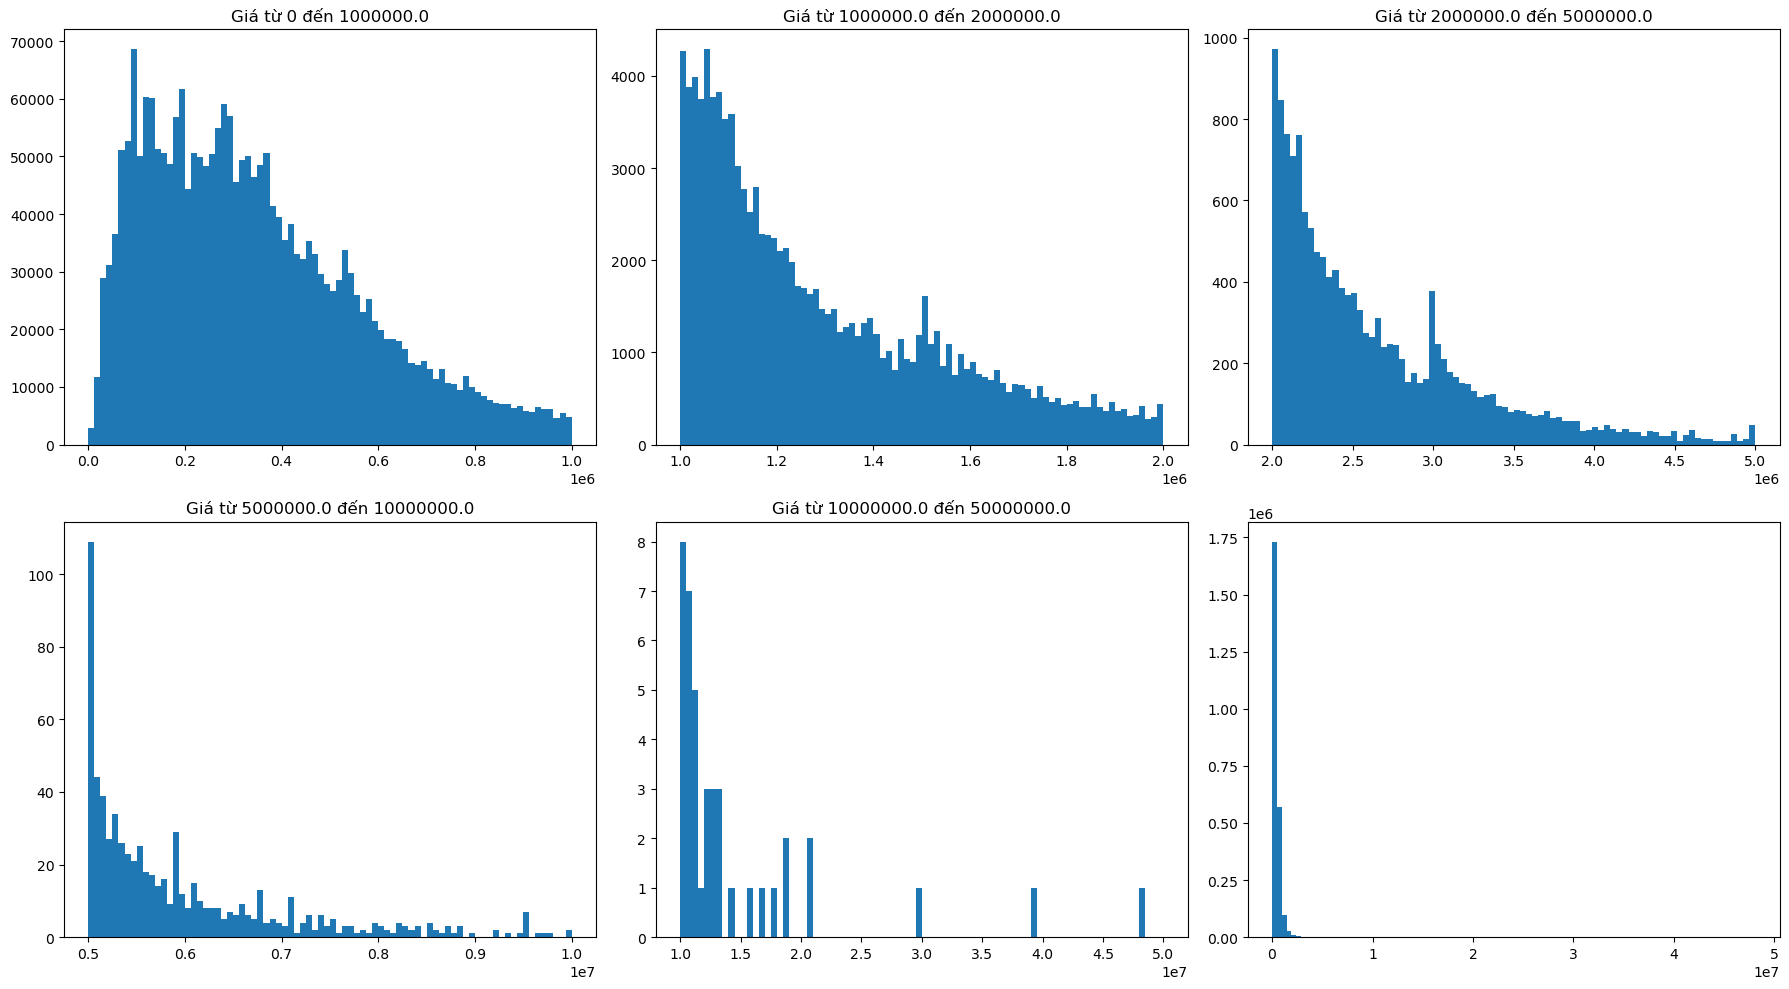

In [6]:
pd = avg_transaction_df.select(pl.col('avg_transaction_value')).to_numpy()

ranges = [(0, 1e6), (1e6, 2e6), (2e6, 5e6), (5e6, 1e7), (1e7, 5e7)]
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()
for ax, binrange in zip(axes[:-1], ranges):
    ax.hist(x=pd, range=binrange, bins=80)
    ax.set_title(f"Giá từ {binrange[0]} đến {binrange[1]}")
axes[-1].hist(x=pd, bins=100)

plt.tight_layout()
plt.show()

## Phân cấp khách hàng

In [7]:
X = avg_transaction_df.select("avg_transaction_value").to_numpy()

# Chạy K-Means với 3 cụm
kmeans = KMeans(n_clusters=3, random_state=42, n_init='auto')
clusters = kmeans.fit_predict(X)

# Thêm cột cluster số vào DataFrame
avg_transaction_df = avg_transaction_df.with_columns(
    pl.Series(name="cluster_id", values=clusters)
)

# Lấy tâm cụm
centers = kmeans.cluster_centers_.flatten()

# Sắp xếp theo thứ tự tăng dần
order = np.argsort(centers)

# Tạo ánh xạ từ cluster_id ban đầu sang thứ tự đúng
mapping = {old: new for new, old in enumerate(order)}

# Gán lại cluster_id cho đúng thứ tự
avg_transaction_df = avg_transaction_df.with_columns(
    pl.col("cluster_id").replace(mapping)
)

c:\ProgramData\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\ProgramData\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "c:\ProgramData\anaconda3\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "c:\ProgramData\anaconda3\Lib\subprocess.py", line 1039, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
    ~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^

In [8]:
# ánh xạ thủ công
label_map = {
    0: "Bình dân",
    1: "Trung cấp",
    2: "Cao cấp"
}

# Áp dụng ánh xạ để tạo cột nhãn cuối cùng
final_avg_transaction = avg_transaction_df.with_columns(
    pl.col("cluster_id").replace_strict(label_map, default="Unknown").alias("customer_segment_avg_transaction")
)

final_avg_transaction

customer_id,avg_transaction_value,cluster_id,customer_segment_avg_transaction
i32,f64,i32,str
1872353,818000.0,1,"""Trung cấp"""
7629523,415000.0,0,"""Bình dân"""
7379678,388525.0,0,"""Bình dân"""
5631853,363333.333333,0,"""Bình dân"""
2617690,1.3416e6,2,"""Cao cấp"""
…,…,…,…
6870410,590166.66665,1,"""Trung cấp"""
6065980,378000.0,0,"""Bình dân"""
7609176,85000.0,0,"""Bình dân"""


### Trực quan

<Axes: xlabel='customer_segment_avg_transaction', ylabel='count'>

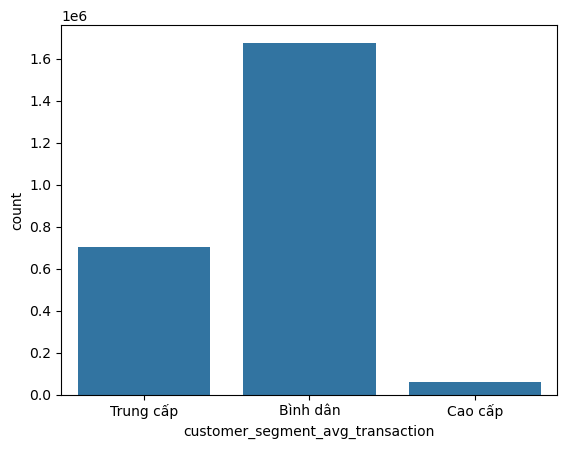

In [9]:
sns.countplot(x=final_avg_transaction['customer_segment_avg_transaction'])

# Đặc trưng 2: Số loại sản phẩm (category_l1) trung bình cho một lần mua hàng, và phân cụm số loại giao dịch trung bình đó, gán vào 3 nhãn "Mua ít", "Mua vừa" và "Mua nhiều".

## Tìm số loại sản phẩm mà mỗi khách hàng mua, theo ngày

In [10]:
joined = purchase_df.select(['customer_id', 'created_date', 'item_id']).collect().join(
    item_df.select(["item_id", "category_l1"]).collect(),
    on="item_id",
    how="inner"
)
joined

customer_id,created_date,item_id,category_l1
i32,datetime[μs],str,str
5254214,2024-12-24 18:17:01.027,"""7115000000004""","""Thực phẩm cho bé"""
7573232,2024-12-24 19:28:01.870,"""0029130000030""","""Thực phẩm cho bé"""
8187418,2024-12-24 19:50:43.760,"""3496000000053""","""Thời trang"""
8187418,2024-12-24 19:49:39.223,"""2700000000002""","""Vệ sinh"""
6931560,2024-12-28 09:49:33.780,"""0029110000036""","""Thực phẩm cho bé"""
…,…,…,…
6848354,2024-10-18 16:28:33.130,"""1396000000020""","""Thực phẩm cho bé"""
5745481,2024-10-19 13:40:19.900,"""0007070000403""","""Babycare"""
3307869,2024-10-19 10:51:21.297,"""4371000000001""","""Thực phẩm cho bé"""


In [11]:
count_item_df = joined.group_by(["customer_id", "created_date"]).agg(
    (pl.col("category_l1")).n_unique().alias("category_l1_count")
)

count_item_df

customer_id,created_date,category_l1_count
i32,datetime[μs],u32
1482663,2024-11-17 18:17:17.907,4
7721849,2024-12-08 16:04:30.533,1
1632585,2024-11-20 20:50:03.340,1
158947,2024-03-18 18:57:54.787,1
1596268,2024-07-09 20:23:35.747,3
…,…,…
4675087,2024-04-03 10:36:57.247,3
4192254,2024-12-02 18:13:02.687,2
7455352,2024-09-29 08:46:10.417,1


## Tìm số loại sản phẩm trung bình mà mỗi khách hàng mua

In [12]:
avg_count_item_df = count_item_df.group_by("customer_id").agg(
    pl.col("category_l1_count").mean().alias("avg_category_l1_value")
)

avg_count_item_df

customer_id,avg_category_l1_value
i32,f64
6403274,1.875
7799398,2.0
6522160,1.0
5289995,1.0
5469451,1.5
…,…
7558574,1.6
2850064,1.0
6564345,1.125


## Phân cấp khách hàng

In [13]:
X = avg_count_item_df.select("avg_category_l1_value").to_numpy()

# Chạy K-Means với 3 cụm
kmeans = KMeans(n_clusters=3, random_state=42, n_init='auto')
clusters = kmeans.fit_predict(X)

# Thêm cột cluster số vào DataFrame
avg_count_item_df = avg_count_item_df.with_columns(
    pl.Series(name="cluster_id", values=clusters)
)

# Lấy tâm cụm
centers = kmeans.cluster_centers_.flatten()

# Sắp xếp theo thứ tự tăng dần
order = np.argsort(centers)

# Tạo ánh xạ từ cluster_id ban đầu sang thứ tự đúng
mapping = {old: new for new, old in enumerate(order)}

# Gán lại cluster_id cho đúng thứ tự
avg_count_item_df = avg_count_item_df.with_columns(
    pl.col("cluster_id").replace(mapping)
)

In [14]:
# ánh xạ thủ công
label_map = {
    0: "Mua ít",
    1: "Mua vừa",
    2: "Mua nhiều"
}

# Áp dụng ánh xạ để tạo cột nhãn cuối cùng
final_avg_count_item_df = avg_count_item_df.with_columns(
    pl.col("cluster_id").replace_strict(label_map, default="Unknown").alias("customer_segment_avg_count_item")
)

final_avg_count_item_df

customer_id,avg_category_l1_value,cluster_id,customer_segment_avg_count_item
i32,f64,i32,str
6403274,1.875,1,"""Mua vừa"""
7799398,2.0,1,"""Mua vừa"""
6522160,1.0,0,"""Mua ít"""
5289995,1.0,0,"""Mua ít"""
5469451,1.5,0,"""Mua ít"""
…,…,…,…
7558574,1.6,0,"""Mua ít"""
2850064,1.0,0,"""Mua ít"""
6564345,1.125,0,"""Mua ít"""


### Trực quan

<Axes: xlabel='customer_segment_avg_count_item', ylabel='count'>

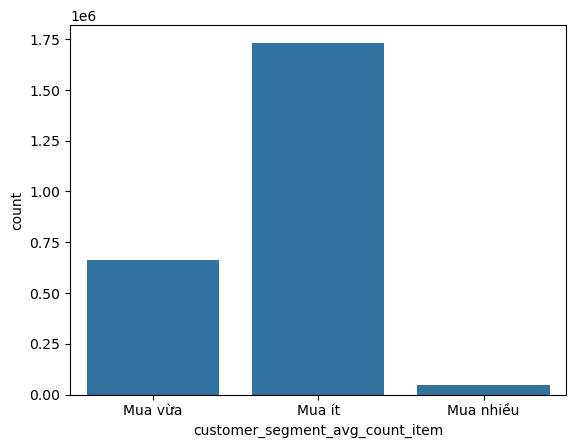

In [15]:
sns.countplot(x=final_avg_count_item_df['customer_segment_avg_count_item'])

# Đặc  trưng 3: Đặc trưng cao cấp của khách hàng dựa trên category "sữa". 

   - Bước 1: Gom nhóm giá các mặt hàng có category_l1 = 'sữa' theo các nhãn "Bình dân", "Trung cấp" và "cao cấp".

   - Bước 2: Thống kê xem khách hàng đó mua sữa thuộc nhóm nào nhiều nhất để gán nhãn cho khách hàng đó.

## Khám phá dữ liệu

In [16]:
sua_df = item_df.filter(
    pl.col('category_l1').str.contains("Sữa")
).collect()

sua_df.select(pl.col("price")).describe()

statistic,price
str,f64
"""count""",603.0
"""null_count""",0.0
"""mean""",403017.412935
"""std""",287892.828744
"""min""",14000.0
"""25%""",115000.0
"""50%""",395000.0
"""75%""",590000.0
"""max""",1.295e6


<Axes: xlabel='price', ylabel='Count'>

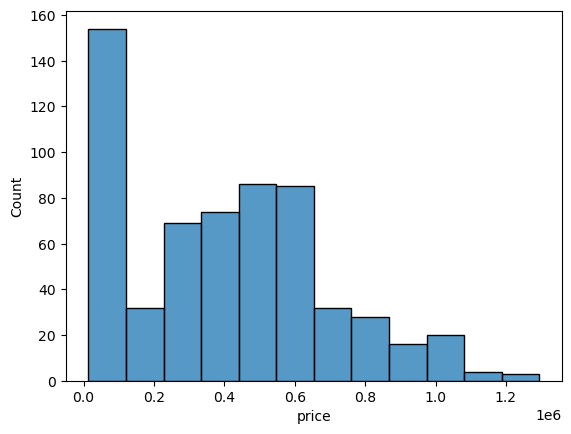

In [17]:
sns.histplot(x=sua_df['price'])

## Phân cấp sữa

In [18]:
sua_df = sua_df.with_columns(
    pl.when(pl.col("price") <= 4.5e5)
      .then(pl.lit("Bình dân"))
    .when(pl.col("price") <= 7.5e5)
      .then(pl.lit("Trung cấp"))
    .otherwise(pl.lit("Cao cấp"))
    .alias("sua_segment")
)

### Kiểm tra kép phân khúc sữa

In [19]:
sua_df.select(pl.col(['item_id', 'price', 'sua_segment'])).filter(
    pl.col('sua_segment') == "Bình dân"
)

item_id,price,sua_segment
str,"decimal[38,4]",str
"""0020010000492""",219000.0000,"""Bình dân"""
"""0020010000289""",229000.0000,"""Bình dân"""
"""0020010000307""",329000.0000,"""Bình dân"""
"""0028020000014""",33000.0000,"""Bình dân"""
"""2006000000003""",107000.0000,"""Bình dân"""
…,…,…
"""6751000000002""",41500.0000,"""Bình dân"""
"""6751000000003""",59000.0000,"""Bình dân"""
"""4666000000003""",254000.0000,"""Bình dân"""


In [20]:
sua_df.select(pl.col(['item_id', 'price', 'sua_segment'])).filter(
    pl.col('sua_segment') == "Trung cấp"
)

item_id,price,sua_segment
str,"decimal[38,4]",str
"""0020010000438""",529000.0000,"""Trung cấp"""
"""0020010000440""",465000.0000,"""Trung cấp"""
"""0020010000299""",519000.0000,"""Trung cấp"""
"""2552000000001""",479000.0000,"""Trung cấp"""
"""0020010000303""",519000.0000,"""Trung cấp"""
…,…,…
"""7391000000002""",569000.0000,"""Trung cấp"""
"""4666000000004""",625000.0000,"""Trung cấp"""
"""4667000000003""",589000.0000,"""Trung cấp"""


In [21]:
sua_df.select(pl.col(['item_id', 'price', 'sua_segment'])).filter(
    pl.col('sua_segment') == "Cao cấp"
)

item_id,price,sua_segment
str,"decimal[38,4]",str
"""1158000000004""",869000.0000,"""Cao cấp"""
"""2403000000002""",799000.0000,"""Cao cấp"""
"""4726000000002""",795000.0000,"""Cao cấp"""
"""3863000000001""",1069000.0000,"""Cao cấp"""
"""4951000000005""",795000.0000,"""Cao cấp"""
…,…,…
"""3773000000004""",764000.0000,"""Cao cấp"""
"""6902000000002""",990000.0000,"""Cao cấp"""
"""6904000000002""",890000.0000,"""Cao cấp"""


### Trực quan

<Axes: xlabel='sua_segment', ylabel='count'>

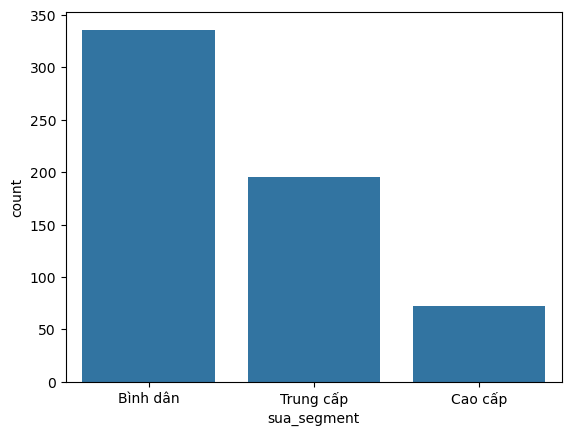

In [22]:
order = sua_df.select(pl.col('sua_segment'))
sns.countplot(x=sua_df['sua_segment'], order=['Bình dân', 'Trung cấp', 'Cao cấp'])

## Kết hợp với lịch sử giao dịch

In [23]:
joined = purchase_df.select(['customer_id', 'item_id', 'quantity']).collect().join(
    sua_df.select(["item_id", "sua_segment"]),
    on="item_id",
    how="inner"
)
joined

customer_id,item_id,quantity,sua_segment
i32,str,i32,str
7573978,"""0020010000438""",2,"""Trung cấp"""
7901749,"""3773000000004""",1,"""Cao cấp"""
7555248,"""3773000000004""",1,"""Cao cấp"""
7416679,"""2578000000002""",2,"""Trung cấp"""
7606905,"""1155000000001""",1,"""Bình dân"""
…,…,…,…
4628405,"""2504000000003""",1,"""Bình dân"""
7596844,"""4559000000004""",12,"""Bình dân"""
2165509,"""3775000000003""",1,"""Trung cấp"""


## Phân cấp khách hàng theo sữa

### Tìm số lượng sữa ở mỗi phân khúc mà mỗi khách hàng mua

In [24]:
summary = joined.group_by(['customer_id', 'sua_segment']).agg(pl.sum('quantity').alias('total_bought'))
summary

customer_id,sua_segment,total_bought
i32,str,i32
7896720,"""Bình dân""",30
7848767,"""Bình dân""",2
7965627,"""Bình dân""",1
6976777,"""Trung cấp""",43
4216693,"""Bình dân""",3
…,…,…
8171953,"""Bình dân""",12
4309434,"""Trung cấp""",2
392727,"""Cao cấp""",12


### Tìm phân khúc sữa mà mỗi khách hàng mua nhiều nhất

In [25]:
final_sua = summary.sort('total_bought', descending=True).group_by('customer_id').agg(pl.first('sua_segment').alias('customer_segment_sua'))
final_sua

customer_id,customer_segment_sua
i32,str
7372467,"""Bình dân"""
2678379,"""Bình dân"""
7420324,"""Bình dân"""
7260911,"""Bình dân"""
5981056,"""Trung cấp"""
…,…
6810254,"""Cao cấp"""
6235465,"""Bình dân"""
6707865,"""Trung cấp"""


### Trực quan

<Axes: xlabel='customer_segment_sua', ylabel='count'>

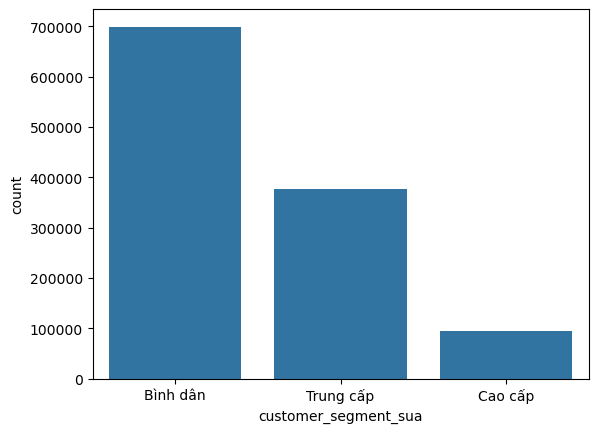

In [26]:
sns.countplot(x=final_sua['customer_segment_sua'], order=['Bình dân', 'Trung cấp', 'Cao cấp'])

# Đặc  trưng 4: Đặc trưng cao cấp của khách hàng dựa trên category "tã". 

   - Bước 1: Gom nhóm giá các mặt hàng có category_l1 = 'tã' theo các nhãn "Bình dân", "Trung cấp" và "cao cấp".

   - Bước 2: Thống kê xem khách hàng đó mua tãthuộc nhóm nào nhiều nhất để gán nhãn cho khách hàng đó.

## Khám phá dữ liệu

In [27]:
ta_df = item_df.filter(
    pl.col('category_l1').str.contains("Tã"),
).collect()

ta_df.select(pl.col("price")).describe()

statistic,price
str,f64
"""count""",442.0
"""null_count""",0.0
"""mean""",301187.791855
"""std""",132196.214063
"""min""",1.0
"""25%""",199000.0
"""50%""",305000.0
"""75%""",379000.0
"""max""",1.32e6


<Axes: xlabel='price', ylabel='Count'>

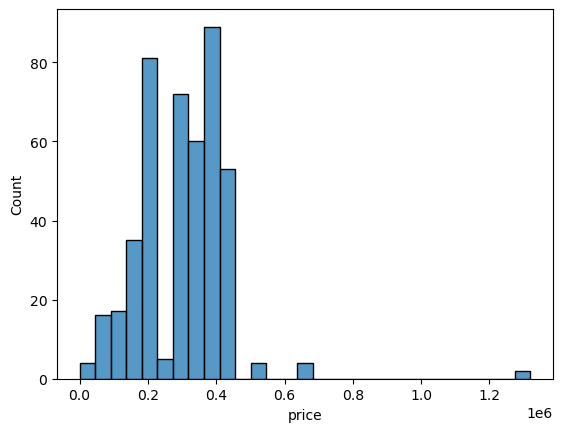

In [28]:
sns.histplot(x=ta_df['price'])

## Phân cấp tã

In [29]:
ta_df = ta_df.with_columns(
    pl.when(pl.col("price") <= 3.5e5)
      .then(pl.lit("Bình dân"))
    .when(pl.col("price") <= 4.2e5)
      .then(pl.lit("Trung cấp"))
    .otherwise(pl.lit("Cao cấp"))
    .alias("ta_segment")
)

### Kiểm tra kép phân khúc tã

In [30]:
ta_df.select(pl.col(['item_id', 'price', 'ta_segment'])).filter(
    pl.col('ta_segment') == "Bình dân"
)

item_id,price,ta_segment
str,"decimal[38,4]",str
"""0020030000001""",319000.0000,"""Bình dân"""
"""0020010000083""",89000.0000,"""Bình dân"""
"""2242000000005""",295000.0000,"""Bình dân"""
"""0020010000244""",109000.0000,"""Bình dân"""
"""5076000000002""",205000.0000,"""Bình dân"""
…,…,…
"""6767000000002""",285000.0000,"""Bình dân"""
"""5074000000001""",180000.0000,"""Bình dân"""
"""2263000000019""",299000.0000,"""Bình dân"""


In [31]:
ta_df.select(pl.col(['item_id', 'price', 'ta_segment'])).filter(
    pl.col('ta_segment') == "Trung cấp"
)

item_id,price,ta_segment
str,"decimal[38,4]",str
"""0020010000094""",401000.0000,"""Trung cấp"""
"""0020010000098""",401000.0000,"""Trung cấp"""
"""0020010000150""",355000.0000,"""Trung cấp"""
"""0020010000151""",379000.0000,"""Trung cấp"""
"""0020010000396""",401000.0000,"""Trung cấp"""
…,…,…
"""2277000000008""",401000.0000,"""Trung cấp"""
"""2231000000029""",391000.0000,"""Trung cấp"""
"""4406000000004""",411000.0000,"""Trung cấp"""


In [32]:
ta_df.select(pl.col(['item_id', 'price', 'ta_segment'])).filter(
    pl.col('ta_segment') == "Cao cấp"
)

item_id,price,ta_segment
str,"decimal[38,4]",str
"""2278000000037""",448000.0000,"""Cao cấp"""
"""2278000000039""",448000.0000,"""Cao cấp"""
"""2285000000002""",445000.0000,"""Cao cấp"""
"""2286000000002""",445000.0000,"""Cao cấp"""
"""2287000000001""",445000.0000,"""Cao cấp"""
…,…,…
"""2278000000016""",430000.0000,"""Cao cấp"""
"""2278000000017""",430000.0000,"""Cao cấp"""
"""5073000000002""",430000.0000,"""Cao cấp"""


### Trực quan

<Axes: xlabel='ta_segment', ylabel='count'>

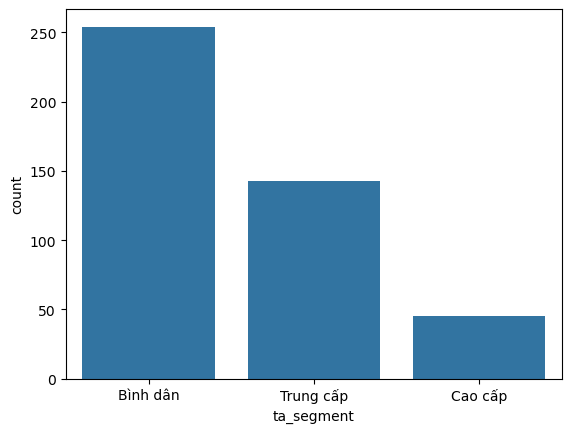

In [33]:
order = ta_df.select(pl.col('ta_segment'))
sns.countplot(x=ta_df['ta_segment'], order=['Bình dân', 'Trung cấp', 'Cao cấp'])

## Kết hợp với lịch sử giao dịch

In [34]:
joined = purchase_df.select(['customer_id', 'item_id', 'quantity']).collect().join(
    ta_df.select(["item_id", "ta_segment"]),
    on="item_id",
    how="inner"
)
joined

customer_id,item_id,quantity,ta_segment
i32,str,i32,str
3353278,"""2242000910001""",1,"""Bình dân"""
4810993,"""2263000000021""",2,"""Bình dân"""
5049831,"""2242000910001""",1,"""Bình dân"""
7081375,"""6768000000005""",1,"""Bình dân"""
4927421,"""2265000000025""",1,"""Trung cấp"""
…,…,…,…
7342594,"""2263000000020""",1,"""Bình dân"""
5068119,"""4644000000001""",2,"""Bình dân"""
7572363,"""2231000000012""",1,"""Trung cấp"""


## Phân cấp khách hàng theo tã

### Tìm số lượng tã ở mỗi phân khúc mà mỗi khách hàng mua

In [35]:
summary = joined.group_by(['customer_id', 'ta_segment']).agg(pl.sum('quantity').alias('total_bought'))
summary

customer_id,ta_segment,total_bought
i32,str,i32
7404763,"""Bình dân""",1
2511410,"""Bình dân""",1
8193829,"""Bình dân""",1
6105259,"""Bình dân""",10
6635144,"""Trung cấp""",19
…,…,…
2815933,"""Bình dân""",9
7927154,"""Bình dân""",1
6829196,"""Bình dân""",13


### Tìm phân khúc tã mà mỗi khách hàng mua nhiều nhất

In [36]:
final_ta = summary.sort('total_bought', descending=True).group_by('customer_id').agg(pl.first('ta_segment').alias('customer_segment_ta'))
final_ta

customer_id,customer_segment_ta
i32,str
7702401,"""Bình dân"""
3377949,"""Bình dân"""
1957551,"""Bình dân"""
6072301,"""Cao cấp"""
6563059,"""Bình dân"""
…,…
2871560,"""Trung cấp"""
5659750,"""Trung cấp"""
3844034,"""Bình dân"""


### Trực quan

<Axes: xlabel='customer_segment_ta', ylabel='count'>

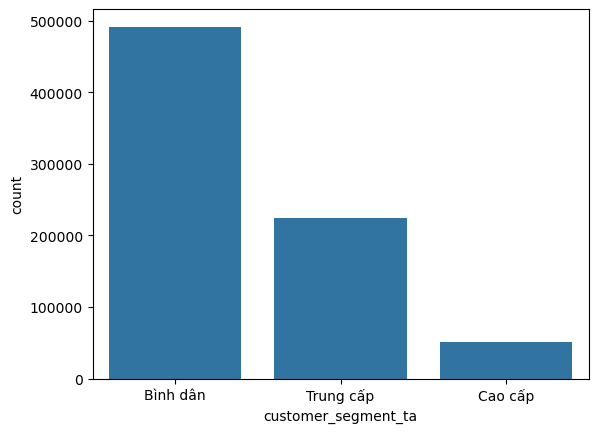

In [37]:
sns.countplot(x=final_ta['customer_segment_ta'], order=['Bình dân', 'Trung cấp', 'Cao cấp'])